In [1]:
import os
import json
import sys
sys.path.append("../")

from tqdm import tqdm
from collections import defaultdict
import numpy as np
import utils
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

from skmultilearn.model_selection import iterative_train_test_split

/home/joanna/miniconda3/envs/default-env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
data_dir = "../../data/google_patents/24054-jp-patents"
data_ratio = {"train": 0.8, "dev": 0.1, "test": 0.1}
random_state = np.random.RandomState(1)

save_data_path = os.path.join(data_dir, "data_500.ndjson")
save_label_path = os.path.join(data_dir, "doc_label_encoder_500.json")

In [3]:
doc_files = utils.get_file_name_in_dir(os.path.join(data_dir, "doc"), "json")
print("Number of document files:", len(doc_files))

Number of document files: 24054


**Data format:**

A .json file contains multiple patents on different lines.

Format of each patent:

```json
{
    "title": str,
    "pdf": str,
    "description": List[str],      # should be concatenated
    "claims": List[str],
    "classifications": List[str],   # each string uses "\n" to separate the cluster ID and its description 
}
```

In [4]:
sample_doc_file = doc_files[2]
with open(sample_doc_file, "r") as f:
    sample_doc = json.load(f)
    print("Document attributes:", sample_doc.keys())

Document attributes: dict_keys(['title', 'pdf', 'classifications', 'description', 'claims'])


In [5]:
sample_doc["classifications"]

['A61N1/0456\nSpecially adapted for transcutaneous electrical nerve stimulation [TENS]',
 'A61N1/0526\nHead electrodes',
 'A61N1/0551\nSpinal or peripheral nerve electrodes',
 'A61N1/36017\nExternal stimulators, e.g. with patch electrodes with leads or electrodes penetrating the skin',
 'A61N1/36025\nExternal stimulators, e.g. with patch electrodes for treating a mental or cerebral condition',
 'A61N1/36031\nControl systems using physiological parameters for adjustment',
 'A61N1/36034\nControl systems specified by the stimulation parameters',
 'A61N1/36053\nImplantable neurostimulators for stimulating central or peripheral nerve system adapted for vagal stimulation',
 'A61N1/36064\nEpilepsy',
 'A61N1/36085\nEating disorders or obesity',
 'A61N1/36089\nAddiction or withdrawal from substance abuse such as alcohol or drugs',
 'A61N1/36096\nMood disorders, e.g. depression, anxiety or panic disorder',
 'A61N1/361\nPhantom sensations, e.g. tinnitus',
 'A61N1/36114\nCardiac control, e.g. by v

In [6]:
def tokens(segments):
    res = []
    for c in segments:
        for x in c.split():
            res.append(x)
    return res

def get_id(doc_file_name):
    x = os.path.basename(doc_file_name)
    return os.path.splitext(x)[0]
    
def get_content(doc):
    return " ".join(tokens(doc["claims"]))

def get_label(doc):
    res = set(x.split("\n")[0][:3] for x in doc["classifications"])
    return list(res)
    
def get_title(doc):
    return doc["title"]

def get_description(doc):
    return " ".join(tokens(doc["description"]))

def get_sample(doc, fname):
    return {
        "id": get_id(fname), "title": get_title(doc), 
        "desc": get_description(doc), "content": get_content(doc), 
        "labels": get_label(doc)
    }

In [7]:
"""
Extract samples from raw data
"""
samples = []
for fname in doc_files:
    with open(fname, "r") as fin:
        doc = json.load(fin)
        if get_label(doc):
            samples.append(get_sample(doc, fname))
            
print("Number of valid documents:", len(samples))

Number of valid documents: 23884


In [8]:
raw_threshold = 520
balance_threshold = 500

In [9]:
"""
Count number of samples/label and discard labels with < 500 samples
"""
def compute_frequency(samples):
    freq = {}
    for x in samples:
        for label in x["labels"]:
            freq[label] = freq.get(label, 0) + 1
    return freq

freq = compute_frequency(samples)
labels = set(k for k, v in freq.items() if v >= raw_threshold)
label_ids = {x : i for i, x in enumerate(labels)}
print("Number of labels:", len(labels))

Number of labels: 21


In [10]:
new_samples = []
for sample in tqdm(samples):
    sample["labels"] = [e for e in sample["labels"] if e in labels]
    if len(sample["labels"]) != 0:
        new_samples.append(sample)

samples = new_samples

100%|██████████| 23884/23884 [00:00<00:00, 1124356.11it/s]


## EDA

In [11]:
import pandas as pd
df = pd.DataFrame(samples)
df

,id,title,desc,content,labels
0,JP6856711B2,半導体装置,Description translated from 本発明は、酸化物半導体を用いる半導体...,ゲート電極層と、 前記ゲート電極層上にゲート絶縁層と、 前記ゲート絶縁層上に酸化物半導体層と...,"[G02, H01]"
1,JP6856704B2,医学的障害の治療のためのデバイス,Description translated from 関連出願の相互参照 [0001] 本...,医学的障害の治療のための三叉神経刺激のためのシステムであって、 パルス発生器と、 前記パルス...,[A61]
2,JP6856696B2,コンテナの管理及びスケジューリングのためのシステム,Description translated from 関連出願の相互参照 本出願は、「ＳＹ...,１つまたは複数のプロセッサと、 前記１つまたは複数のプロセッサによって実行される際、実行可能...,[G06]
3,JP6856695B2,タービン・カートリッジを備えるオーバーハング・タービン及び発電機システム,Description translated from （関連出願のデータ） [0001] ...,シャフトと、 ハウジングと、 複数の固定子板を含む少なくとも１つの固定子であって、前記複数の...,"[H02, Y02, Y10]"
4,JP6856694B2,Ｔｉｍ−３に対する抗体分子およびその使用,Description translated from 関連出願の相互参照 本出願は、米国仮...,（ａ）配列番号９のＶＨＣＤＲ１アミノ酸配列；配列番号１０のＶＨＣＤＲ２アミノ酸配列；および配...,"[G01, A61, Y02, C07]"
...,...,...,...,...,...
22825,JP3194731U,呼吸器及び呼吸器用選択素子,Description translated from 本考案は、気体混合物の処理、特に、人...,患者からの吐出気体のための気体経路に気体分離膜を有し、 その気体分離膜は、希ガスが比較的低浸...,"[B01, A61]"
22826,JP3194569U,保護カバー,Description translated from 本考案は、保護カバーに関するものであ...,収容部と、 前記収容部に設置される緩和部と、 を備えてなる保護カバーであって、 前記収容部に...,[H04]
22827,JP3194297U,自動車用及び産業用のモーション感知制御装置,Description translated from 本願の技術は、自動車用及び産業用の制...,組み込み可能なモーション感知制御装置であって、 眺められている景色の立体的なイメージ情報を提...,"[G01, H04, G06]"
22828,JP3193976U,過熱破壊式安全構造及び過熱破壊式安全構造を備えるコンセントとプラグ,Description translated from 本考案は、動作温度が高くなりすぎた時...,２つの導電部材と、熱変形温度下で変形破壊する位置規制部材とを備える過熱破壊式安全構造であって...,[H01]


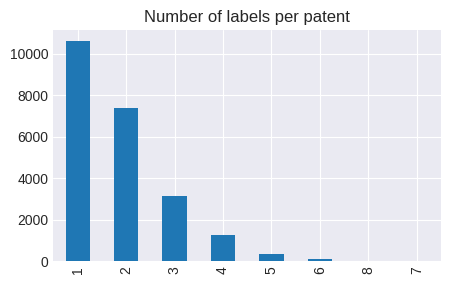

count    22830.000000
mean         1.852124
std          1.019817
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          8.000000
Name: labels, dtype: float64

In [12]:
fig = plt.figure(figsize=(5, 3))
ax = df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");
plt.show()
df["labels"].apply(lambda x : len(x)).describe()

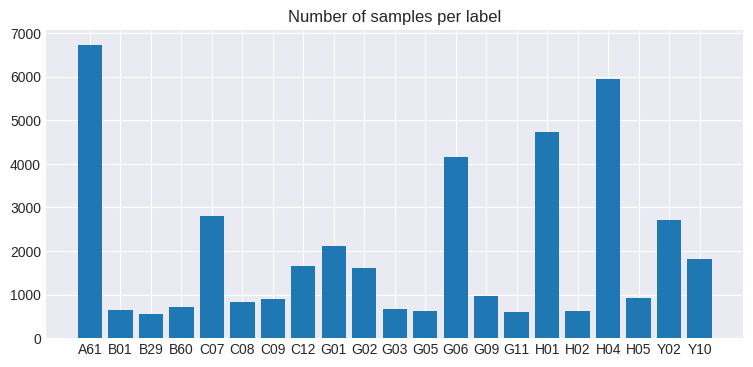

In [13]:
freq = compute_frequency(samples)
freq = {k: freq[k] for k in sorted(freq)}
fig = plt.figure(figsize=(9, 4))
plt.bar(freq.keys(), freq.values())
plt.title("Number of samples per label")
plt.show()

In [14]:
def pivot(arr, keys):
    global sample_label
    a, b = [], []
    for x in arr:
        if keys.intersection(sample_label[x]):
            b.append(x)
        else:
            a.append(x)
    a.extend(b)
    return a

In [15]:
class_label = defaultdict(set)
sample_label = defaultdict(set)
# predominant_labels = set(["H04", "H01", "A61", "G06", "Y10", "A61"])
predominant_labels = set(["H01"])

for rid, labels in df["labels"].iteritems():
    sample_label[rid].update(labels)
    for x in labels:
        class_label[x].add(rid)

selected_samples = set()
selected_labels = set()
curr_class_cnt = defaultdict(lambda : 0)

for label in sorted(freq, key=lambda x : freq.get(x)):
    if len(class_label[label]) <= balance_threshold:
        selected_samples.update(class_label[label])
        selected_labels.add(label)
        continue

    # compute number of samples needed to be drawn (ignoring duplicated samples)
    included_samples = class_label[label].intersection(selected_samples)
    sample_size = max(0, balance_threshold - len(included_samples))

    # samples that contain least unselected labels have the highest priority
    sample_space = list(class_label[label].difference(selected_samples))
    sorted_sample_space = sorted(sample_space, key=lambda x : len(sample_label[x].difference(selected_labels)))
    sorted_sample_space = pivot(sorted_sample_space, predominant_labels)
    choices = random_state.choice(sorted_sample_space[:sample_size + 20], sample_size, replace=False)
    
    selected_samples.update(choices)
    selected_labels.add(label)

new_samples = [x for i, x in enumerate(samples) if i in selected_samples]
print("Number of samples:", len(new_samples))

Number of samples: 5379


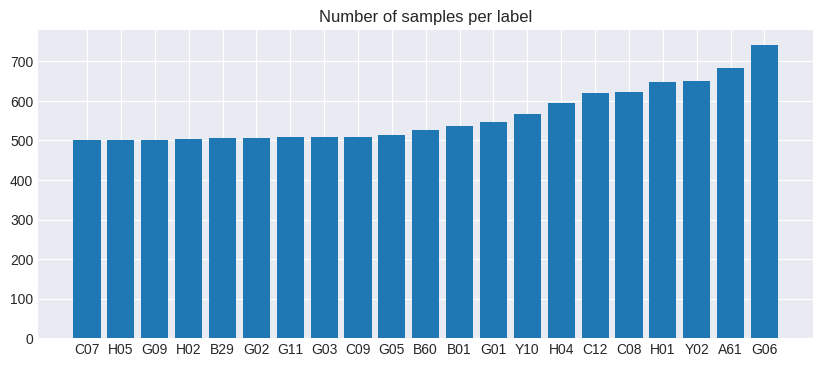

count     21.000000
mean     561.809524
std       72.092731
min      500.000000
25%      506.000000
50%      526.000000
75%      620.000000
max      742.000000
dtype: float64

In [16]:
new_freq = compute_frequency(new_samples)
new_freq = {k: new_freq[k] for k in sorted(new_freq, key=new_freq.get)}
fig = plt.figure(figsize=(10, 4))
plt.bar(new_freq.keys(), new_freq.values())
plt.title("Number of samples per label")
plt.show()
pd.Series(new_freq).describe()

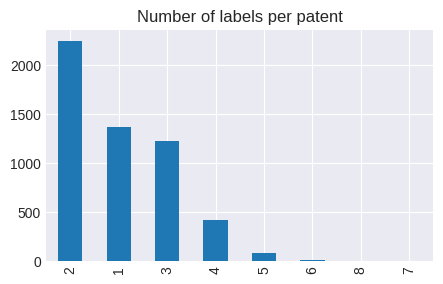

count    5379.000000
mean        2.193344
std         0.988867
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: labels, dtype: float64

In [17]:
new_df = pd.DataFrame(new_samples)
fig = plt.figure(figsize=(5, 3))
ax = new_df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");
plt.show()
new_df["labels"].apply(lambda x : len(x)).describe()

## Data Splitting

In [18]:
df = new_df
samples = new_samples

In [19]:
X_raw = np.array([[x] for x in samples])
y_raw = np.matrix([utils.get_onehot(x["labels"], label_ids) for x in samples])
X, y = {}, {}
y_raw.shape

(5379, 21)

In [20]:
X["train"], y["train"], X["test"], y["test"] = iterative_train_test_split(X_raw, y_raw, test_size=0.1)

In [21]:
# Make sure all sets share the same set of labels
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["test"] == 1)[1]).tolist()))

set()

In [22]:
X["train"], y["train"], X["dev"], y["dev"] = iterative_train_test_split(X["train"], y["train"], test_size=len(y["test"]) / len(y["train"]))

In [23]:
# Make sure all sets share the same set of labels
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["dev"] == 1)[1]).tolist()))

set()

In [24]:
samples = []
for data_type in ("train", "dev", "test"):
    for sample in X[data_type]:
        sample = sample[0]
        sample["is_train"] = sample["is_dev"] = sample["is_test"] = False
        sample[f"is_{data_type}"] = True
        samples.append(sample)

In [25]:
df = pd.DataFrame(samples)
df.head()

,id,title,desc,content,labels,is_train,is_dev,is_test
0,JP6856694B2,Ｔｉｍ−３に対する抗体分子およびその使用,Description translated from 関連出願の相互参照 本出願は、米国仮...,（ａ）配列番号９のＶＨＣＤＲ１アミノ酸配列；配列番号１０のＶＨＣＤＲ２アミノ酸配列；および配...,"[G01, A61, Y02, C07]",True,False,False
1,JP6856657B2,血液学的悪性疾患および固形腫瘍の処置のためのｉｄｈ１阻害剤,Description translated from 本出願は、２０１６年２月２６日に出願...,対象において急性骨髄性白血病（ＡＭＬ）を処置するための組成物であって、以下の式を有する変異体...,"[A61, C07]",True,False,False
2,JP6856541B2,エレクトロニクス機器を冷却する受動的及び能動的な流れ制御を伴うモジュール式の噴流衝当アセンブリ,Description translated from 関連出願に関する相互参照 本出願は、...,流体取入口に対して流体結合された取入管と、 流体吐出口に対して流体結合された吐出管と、 モジ...,"[H05, H01]",True,False,False
3,JP6856534B2,活性化ｔ細胞を用いるがん治療の方法,Description translated from （関連出願の相互参照） 本出願は、２...,個体の肝細胞がんを治療するための、活性化Ｔ細胞を含む組成物であって、前記個体に有効量の活性化...,"[C12, A61]",True,False,False
4,JP6855484B2,下流側の電流ベースのモータ制御を有する外科用ステープラ,Description translated from 本明細書で開示する発明は、外科用器具...,外科用ステープラであって、 駆動システムと、 前記駆動システムに機械的に結合された電気モータ...,"[A61, H02]",True,False,False


In [26]:
num_words = int(df["content"].apply(lambda x : len(x.split())).mean())
num_chars = int(df["content"].apply(lambda x : sum(1 for e in x if e.strip())).mean())
num_train = len(df[df["is_train"] == True])
num_val = len(df[df["is_dev"] == True])
num_test = len(df[df["is_test"] == True])
num_labels = len(label_ids)
print("{} & {} & {} & {} & {} & {}".format(num_train, num_val, num_test, num_words, num_chars, num_labels))

4319 & 529 & 531 & 40 & 2417 & 21


In [27]:
sum(df["is_train"]), sum(df["is_dev"]), sum(df["is_test"])

(4319, 529, 531)

In [28]:
# Check if there is any empty patent
df[df["content"].apply(lambda x : len(x)) == 0]

,id,title,desc,content,labels,is_train,is_dev,is_test


## Save data

In [29]:
with open(save_data_path, "w") as f:
    for sample in tqdm(samples):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")
utils.dump_json(label_ids, save_label_path)

100%|██████████| 5379/5379 [00:02<00:00, 1969.38it/s]
